In [3]:
import numpy as np
import pandas as pd
import seaborn as snd
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv('../all_stocks_5yr.csv')
df.head(100)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
95,2013-06-26,16.50,16.64,16.17,16.17,3604500,AAL
96,2013-06-27,16.29,16.34,16.00,16.31,3566000,AAL
97,2013-06-28,16.24,16.55,16.16,16.42,7063900,AAL
98,2013-07-01,16.50,17.04,16.48,16.80,4666900,AAL


Data Exploration

In [7]:
df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [8]:
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [11]:
df['Name'].unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

Data Cleaning and Pre-Processing

In [23]:
# Dropping the Null columns
df.dropna(inplace=True)

# Changing the Date format from object to Datetime
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   Name    619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


In [36]:
# Calculating the average trade of all stocks in the dataset and sorting it in order to get the Top 10 which will be used for further analysis
data_dict = {}
print("Unique count for ticker column : " , df['Name'].nunique())
print()
for ticker in df['Name'].unique():
    avg = df[df['Name'] == ticker]['volume'].mean()
    data_dict[ticker] = avg
print("All stocks with respective avegrae trade volumes : " ,  data_dict)

sorted_items = sorted(data_dict.items(), key=lambda item: item[1], reverse=True)[:10]
top_10 = {item[0]: item[1] for item in sorted_items}
print()
print("Top 10 stocks with highest trade volume : " , top_10.keys())

Unique count for ticker column :  505

All stocks with respective avegrae trade volumes :  {'AAL': 9390321.324066719, 'AAPL': 54047899.73550437, 'AAP': 1078043.216838761, 'ABBV': 7870682.665607625, 'ABC': 2005738.3232724385, 'ABT': 6964036.691818904, 'ACN': 2596238.098490866, 'ADBE': 2998133.5996822873, 'ADI': 2451738.088959492, 'ADM': 3647857.6870532166, 'ADP': 2022774.221604448, 'ADSK': 2482750.679110405, 'ADS': 619308.5424940429, 'AEE': 1622724.4956314536, 'AEP': 2781243.0254169977, 'AES': 5568655.816521049, 'AET': 2716448.100873709, 'AFL': 2116351.5226370133, 'AGN': 2880076.8125496428, 'AIG': 8419467.383637808, 'AIV': 1198721.3010325655, 'AIZ': 545139.3129467831, 'AJG': 924431.0667196187, 'AKAM': 2182469.447180302, 'ALB': 1160881.819698173, 'ALGN': 885551.828435266, 'ALK': 1537615.6846703733, 'ALLE': 739724.4948259642, 'ALL': 2407102.868149325, 'ALXN': 1762434.8204924543, 'AMAT': 13230027.8649722, 'AMD': 32519037.79666402, 'AME': 1308148.1326449562, 'AMGN': 3465404.566322478, 'AMG'

In [70]:
top_10_stocks = ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']
filtered_df = df[df['Name'].isin(top_10_stocks)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
...,...,...,...,...,...,...,...
12585,2018-02-01,43.0400,44.0900,42.1000,42.4900,35713522,MU
12586,2018-02-02,42.0000,42.2100,40.6100,40.8200,40657381,MU
12587,2018-02-05,40.1400,41.5300,39.0100,39.4000,45796837,MU
12588,2018-02-06,40.5500,43.9300,40.5500,43.8800,66972802,MU


In [77]:
def plot(data, stock_name, price_type):
    data_subset = data[data['Name'] == stock_name ]
    data_subset.reset_index(drop=True, inplace=True)  
    plt.figure(figsize=(16,8))
    plt.plot(data_subset[price_type])
    plt.title(f" {price_type} Price Visualization for {stock_name}")
    plt.xlabel('Days')
    plt.ylabel(f'{price_type} Price Value in USD ')
    plt.show()

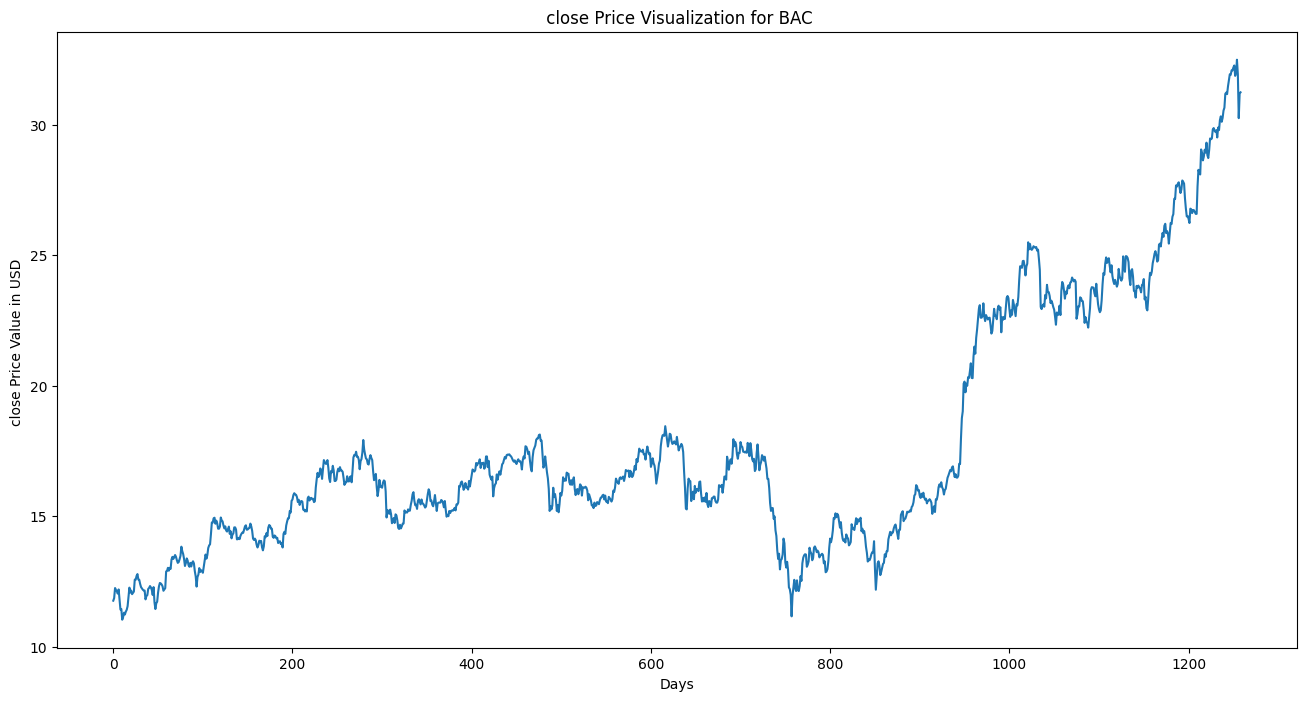

In [78]:
plot(filtered_df, 'BAC', 'close')

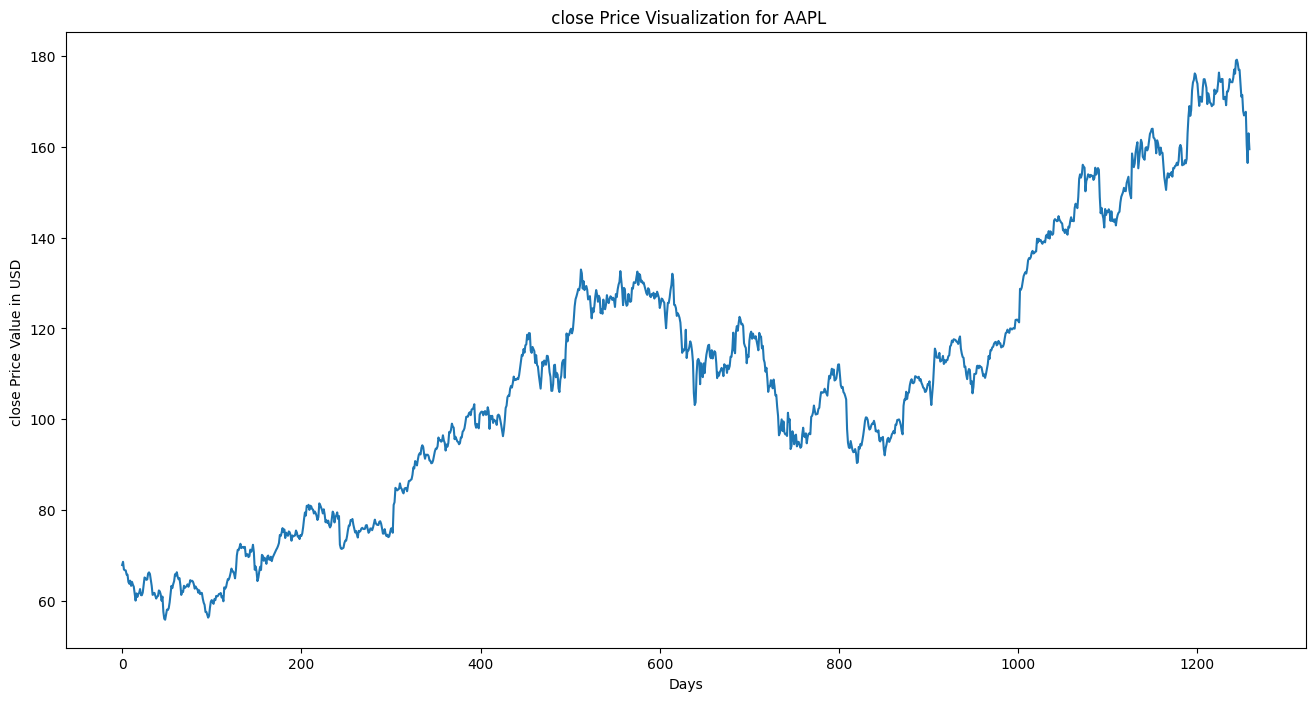

In [79]:
plot(filtered_df, 'AAPL', 'close')

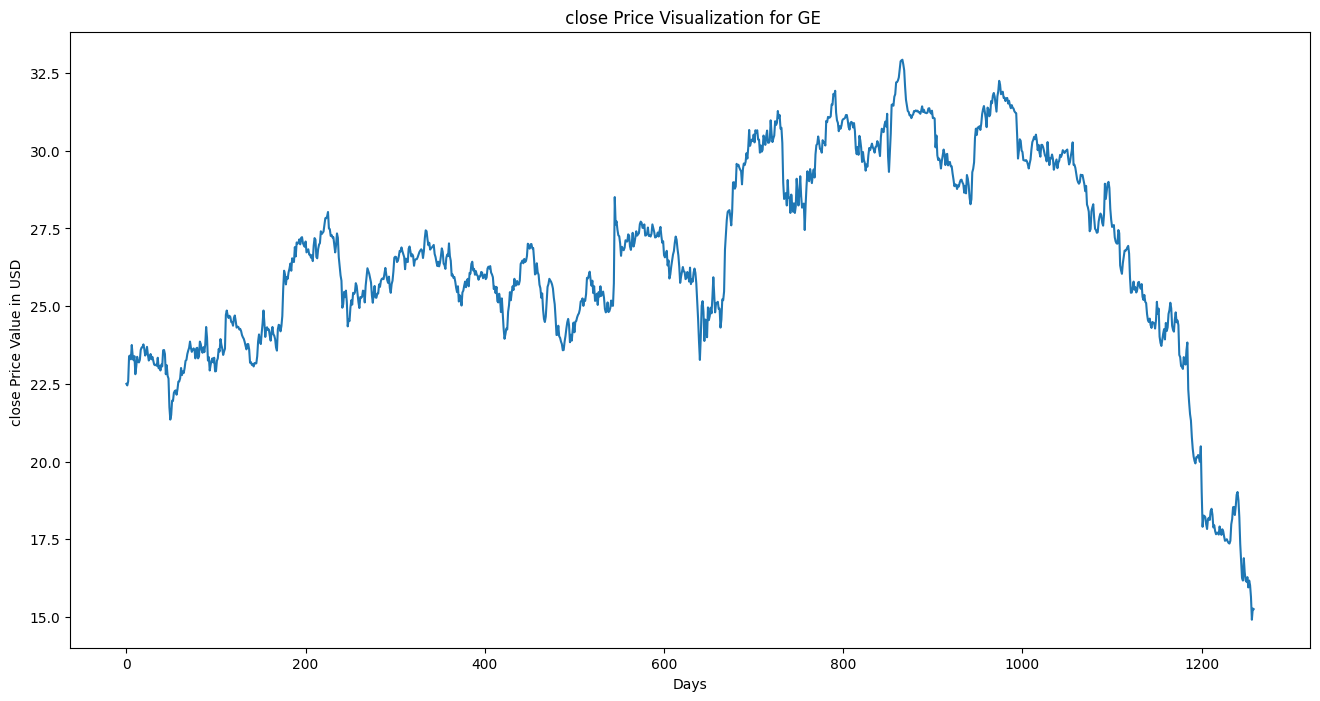

In [80]:
plot(filtered_df, 'GE', 'close')

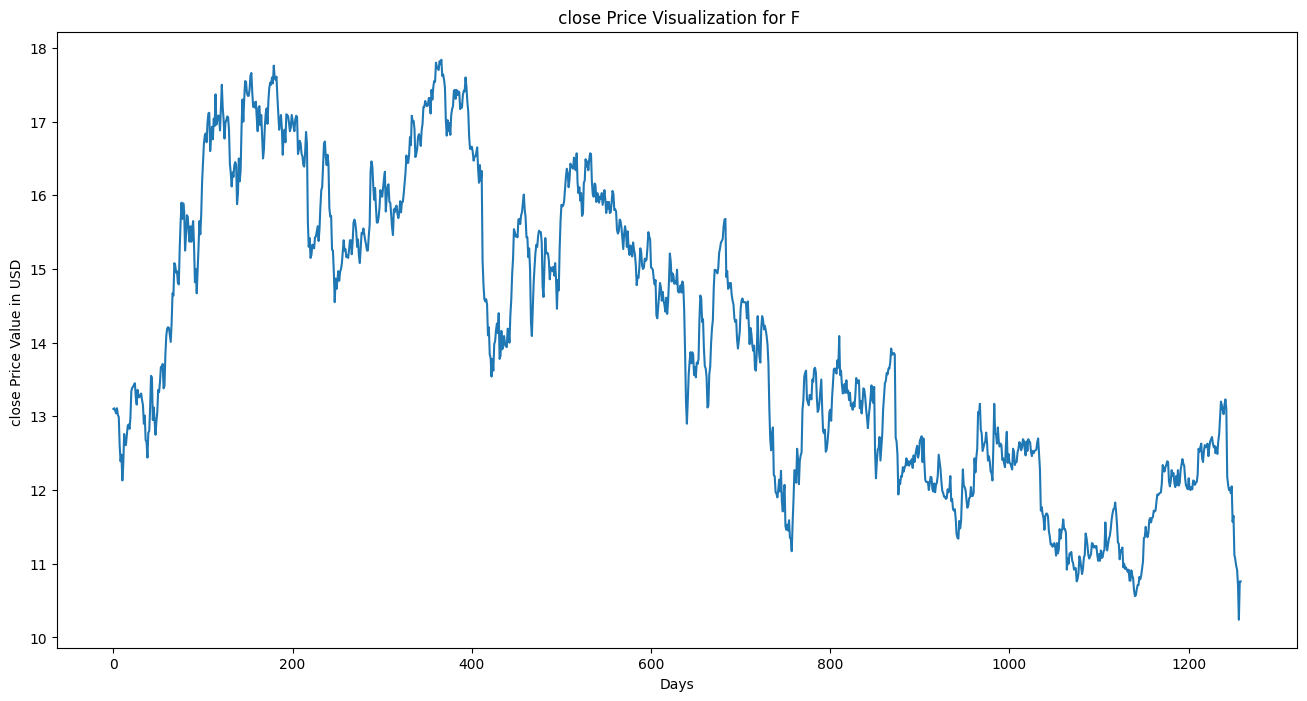

In [81]:
plot(filtered_df, 'F', 'close')

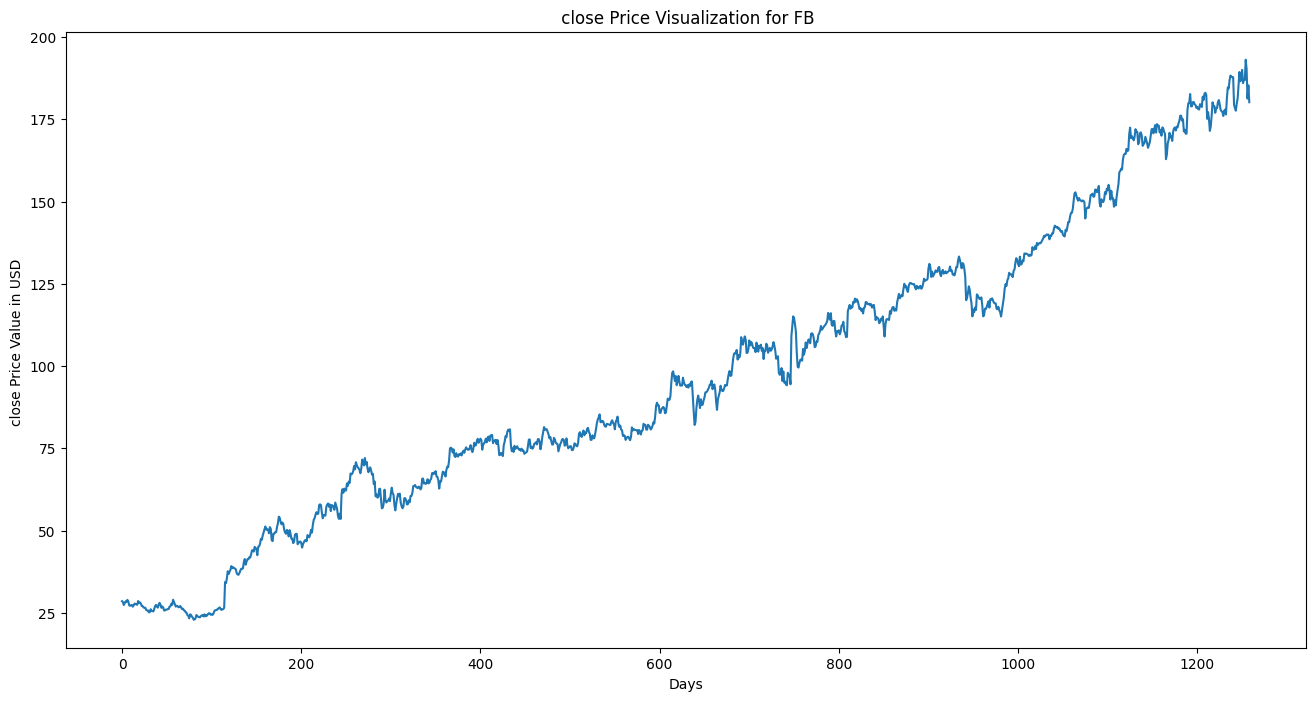

In [82]:
plot(filtered_df, 'FB', 'close')